## Descriptive Statistics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
import numpy as np
from tqdm import tqdm
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import json


plt.style.use('fivethirtyeight')

In [2]:
# The comments are made on the original dataset, not the processed one.
processed = False

if processed:
    df = pd.read_json('../data/processed/train.json')
    df = df.explode('ingredients')
    df.rename(columns={'ingredients':'ingredient'}, inplace=True)

else:
    with open('../data/raw/train.json') as f:
        data = json.load(f)

    # data = load_data()
    column_values = {'id':[],'cuisine':[],'ingredient':[]}
    for dp in data:
        for ingredient in dp['ingredients']:
            column_values['id'].append(dp['id'])
            column_values['cuisine'].append(dp['cuisine'])
            column_values['ingredient'].append(ingredient)
    df = pd.DataFrame(column_values)

df.head()

,id,cuisine,ingredient
0,10259,greek,romaine lettuce
1,10259,greek,black olives
2,10259,greek,grape tomatoes
3,10259,greek,garlic
4,10259,greek,pepper


In [3]:
df.shape

(428275, 3)

## Initial questions
1. How many cuisines do we have? 
2. How many datapoints pr. cuisine

===== 20 unique cuisines =====


2041.5587723728731

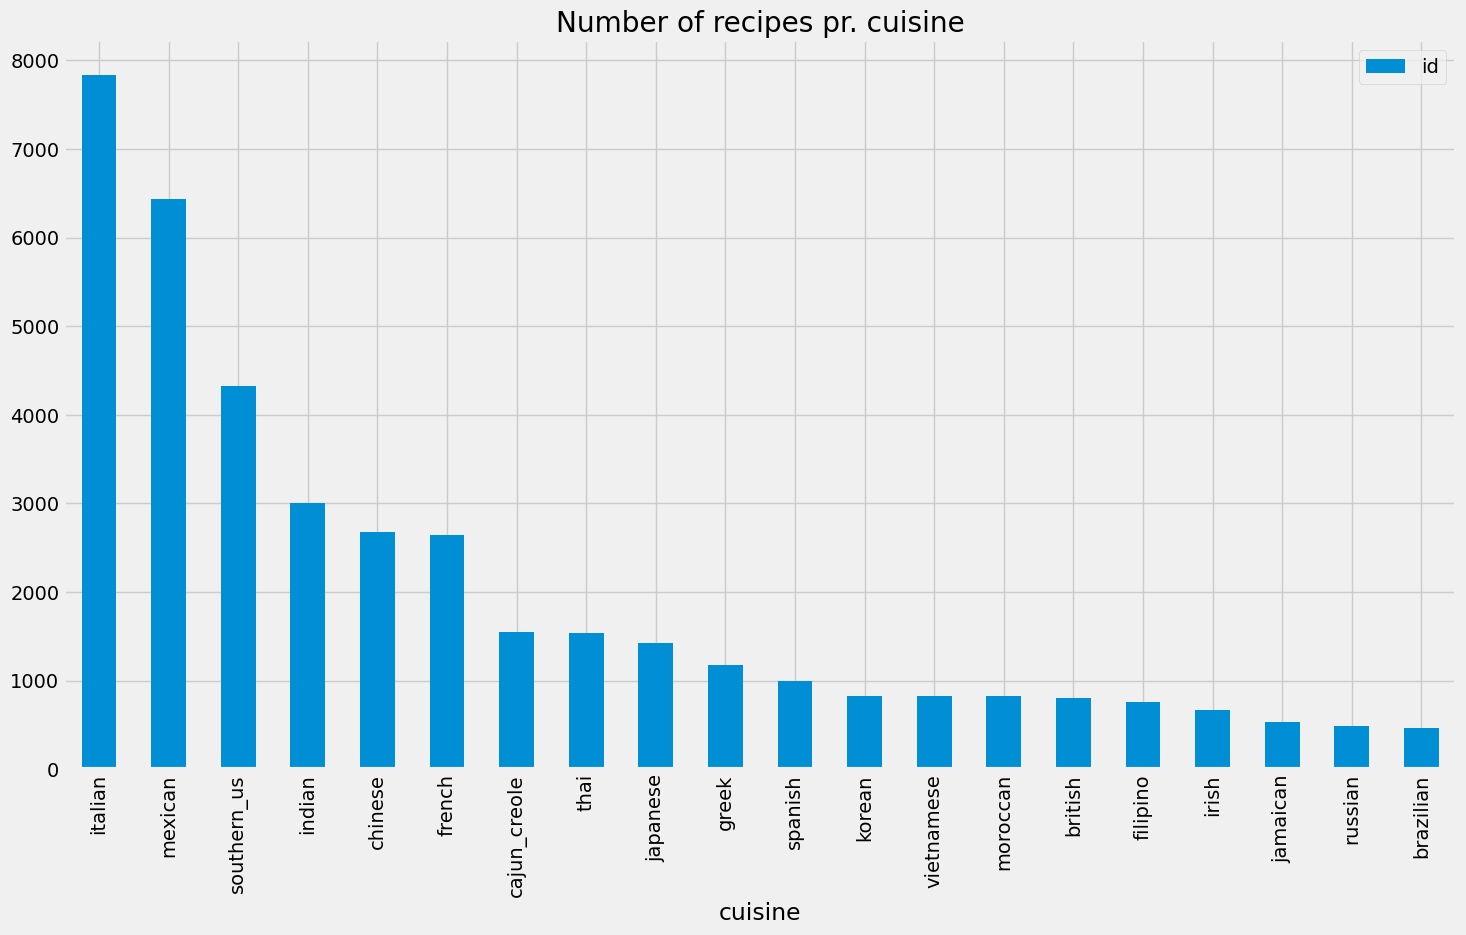

In [4]:
num_dishes = df[['cuisine','id']].drop_duplicates()\
                    .groupby('cuisine').count()\
                    .sort_values('id',ascending=False)
print("===== {} unique cuisines =====".format(num_dishes.shape[0]))
num_dishes.plot(kind='bar',figsize=[16,9],title='Number of recipes pr. cuisine')
num_dishes['id'].std()

### Answering initial questions
We have 20 cuisines, with 7 European, 3 North American, 7 Asian, 2 South American and a single African cuisine. 
There is massive difference in the number of datapoints available from each cuisine, with Mexican and Italian being represented by over 6000 recipes each. Meanwhile, Korean, Brazilian, Russian, Jamaican, Irish, Filipino, British, Moroccan and Vietnamese are all represented by less than 1000 recipes each. 

### Cuisine Uniqueness
This yields the question, whether the smaller cuisines will be harder to model? 
Potentially they have very few dishes that consist of similar ingredients to the more heavily represented cuisines. 
Therfore, we want to find;
1. The distribution of ingredients on cuisines
2. The average recipe length for various cuisines
3. The amount of unique ingredients for a cuisine
4. The amount of recipes containing at least one unique ingredient per cuisine

634.3119334738772


<AxesSubplot: title={'center': 'Number of ingredients pr. cuisine'}, xlabel='cuisine'>

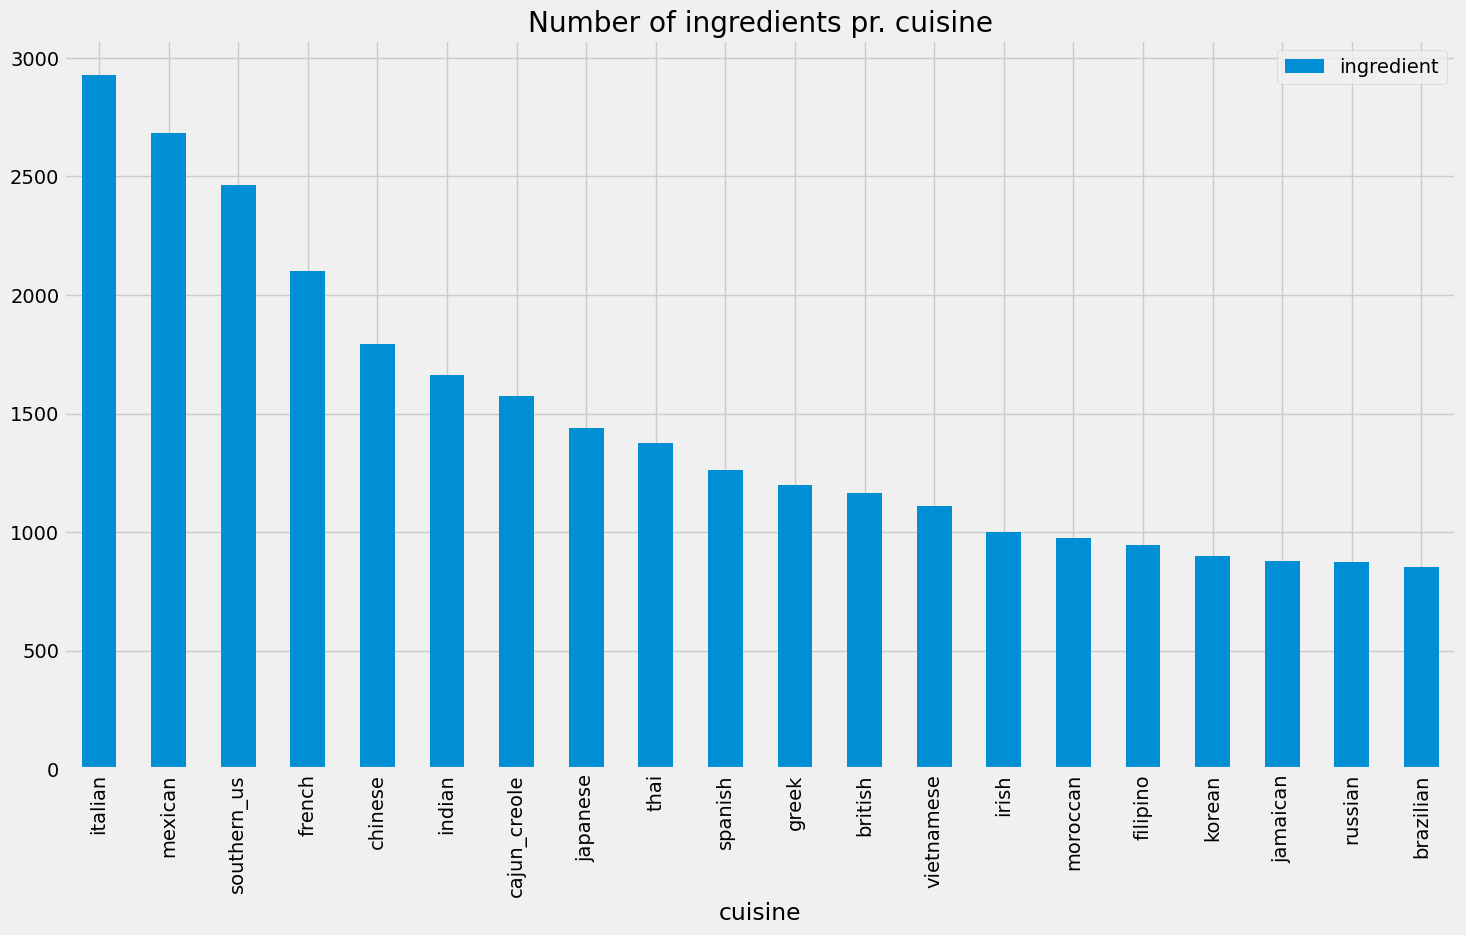

In [5]:
# Calculate the number of unique ingredients pr cuisine
num_ing_cuisine = df[['cuisine','ingredient']].drop_duplicates()\
                    .groupby('cuisine').count()\
                    .sort_values('ingredient',ascending=False)
print(num_ing_cuisine['ingredient'].std())
num_ing_cuisine.plot(kind='bar',figsize=[16,9],title='Number of ingredients pr. cuisine')

<AxesSubplot: title={'center': 'Median reciepe length'}, ylabel='cuisine'>

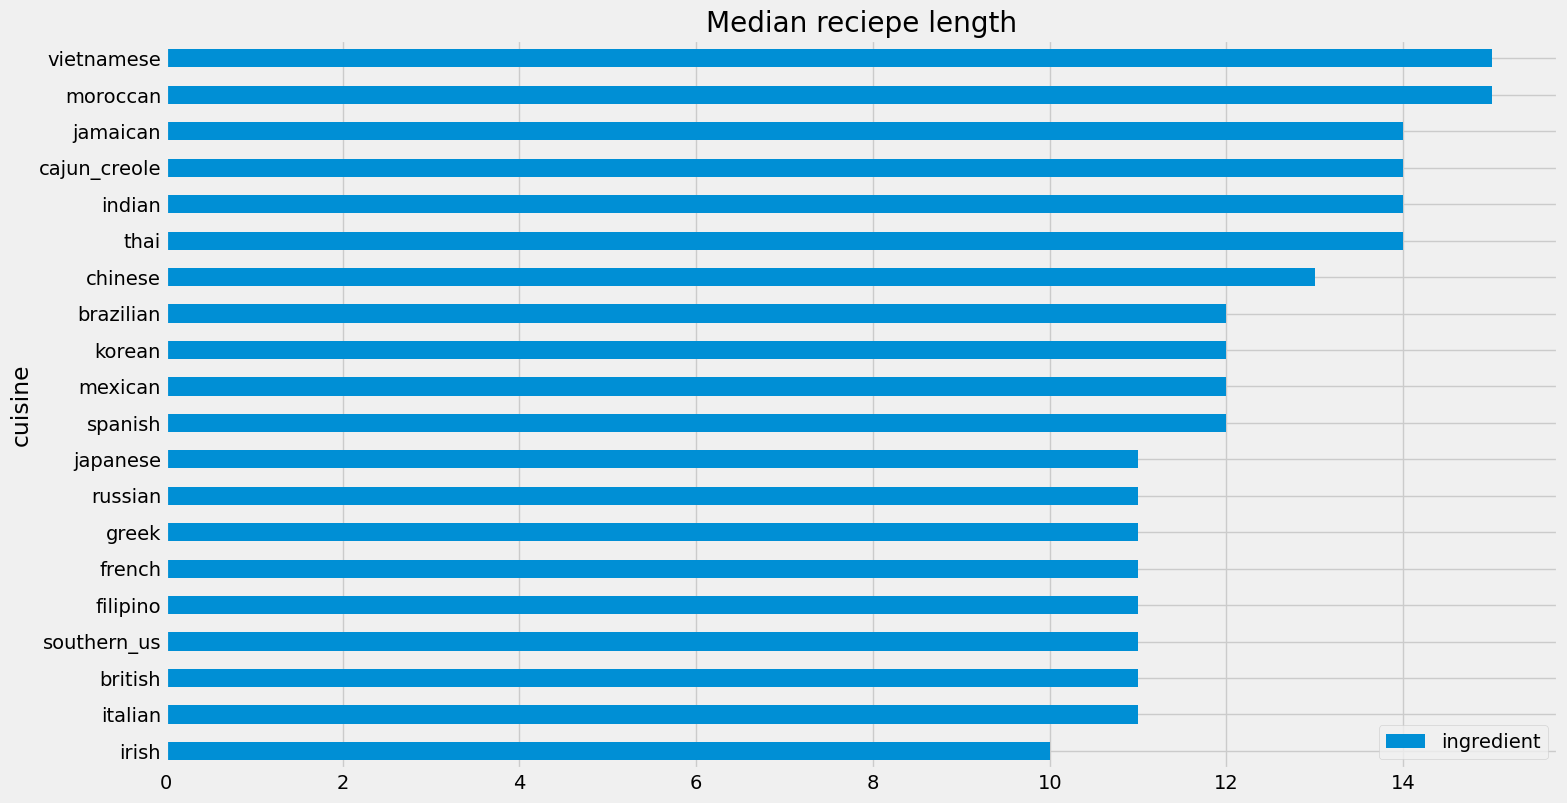

In [6]:
# Calculate the median recipe length for each cuisine
df[['id','ingredient']].groupby(['id'])\
                       .count()\
                       .reset_index()\
                       .merge(df[['cuisine','id']],on='id')[['cuisine','ingredient']]\
                       .groupby('cuisine')\
                       .median()\
                       .sort_values('ingredient',ascending=True)\
                       .plot(kind='barh',
                             figsize=[16,9],
                             title = 'Median reciepe length')

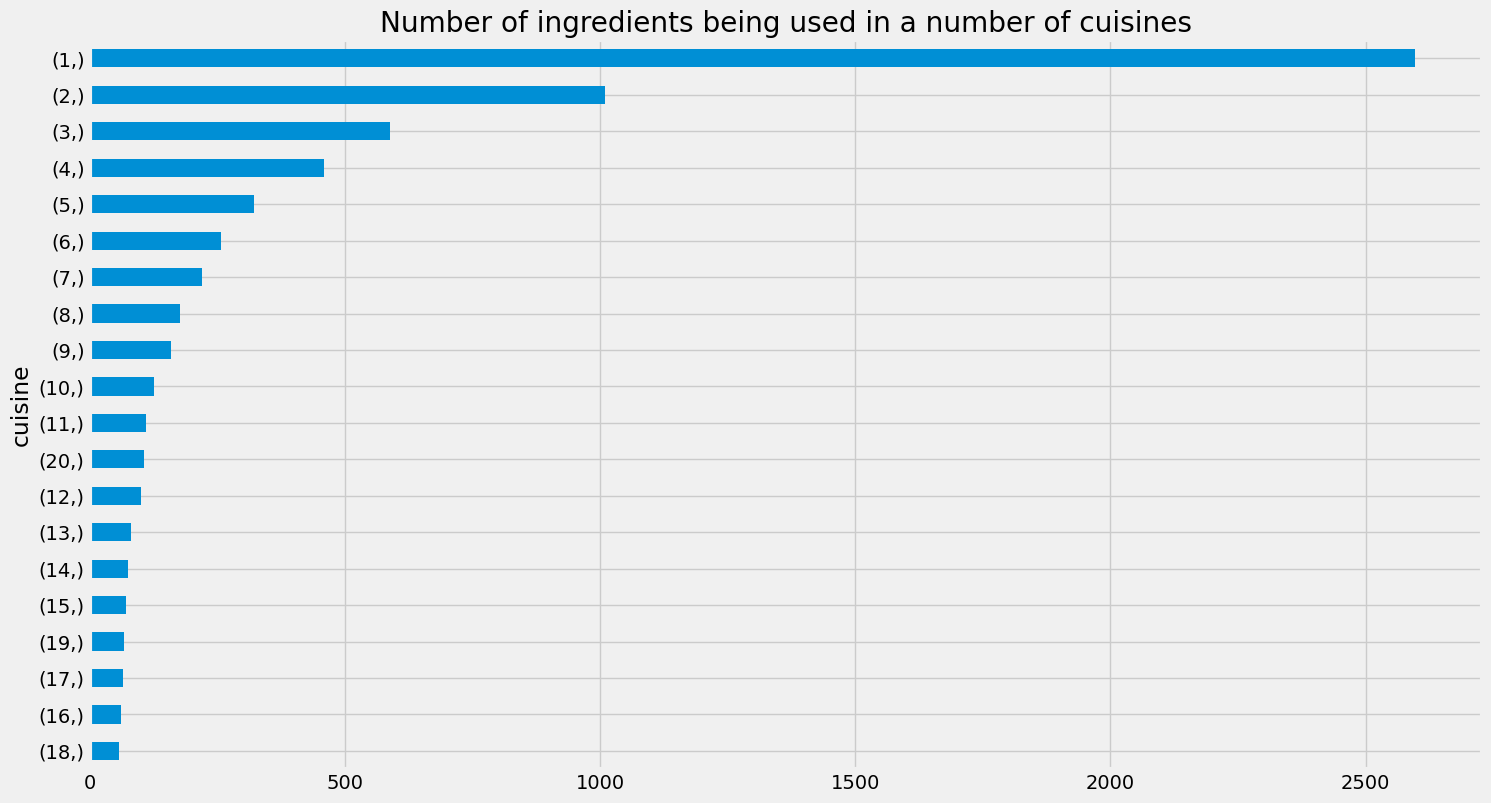

In [7]:
# get the distribution of ingredients over dishes and cuisines
# can be used to find the very unique ingredients
# Plot indicates the number of ingredients that have been used in a single cuisine, or in two, or in three etc.
cuisines = df[['cuisine','ingredient']].drop_duplicates()\
                            .groupby('ingredient')\
                            .aggregate('count')\
                            .sort_values(by='cuisine',
                                         ascending=False)\


cuisine_counts = cuisines.value_counts().sort_values()

cuisine_counts.plot(kind='barh',
                   figsize=[16,9],
                   title='Number of ingredients being used in a number of cuisines')

plt.show()
merge_cusines = cuisines.reset_index()
merge_cusines['used_in_num_cuisines'] = merge_cusines['cuisine']
merge_cusines.drop('cuisine',axis=1,inplace=True)
ingredient_usage = df.merge(merge_cusines,on='ingredient')

In [8]:
## Here we find the percent of dishes that contain an ingredient that is specific to that cuisine
num_cuisines_using_ingredient = 1
num_easily_identifiable_dishes = ingredient_usage.loc[ingredient_usage['used_in_num_cuisines']<=num_cuisines_using_ingredient]\
                    [['cuisine','id']]\
                    .drop_duplicates()\
                    .groupby('cuisine')\
                    .count()\
                    .sort_values('id',
                                 ascending=False)




cuisine_uniqueness = num_easily_identifiable_dishes.reset_index()\
                              .merge(num_dishes.reset_index(),
                                     on='cuisine')

cuisine_uniqueness['num_dishes_containing_unk_element'] = cuisine_uniqueness['id_x']
cuisine_uniqueness['num_dishes'] = cuisine_uniqueness['id_y']
cuisine_uniqueness.drop(['id_x','id_y'],axis=1,inplace=True)
cuisine_uniqueness['percent_of_easily_identifiable_dishes'] = [round(row['num_dishes_containing_unk_element']/row['num_dishes']*100,2) for k,row in cuisine_uniqueness.iterrows()]
cuisine_uniqueness.sort_values('percent_of_easily_identifiable_dishes',
                                ascending=False)\
                  .reset_index()\
                  .drop('index',axis=1)



,cuisine,num_dishes_containing_unk_element,num_dishes,percent_of_easily_identifiable_dishes
0,brazilian,150,467,32.12
1,mexican,1636,6438,25.41
2,jamaican,84,526,15.97
3,japanese,208,1423,14.62
4,filipino,108,755,14.30
5,italian,1067,7838,13.61
6,british,105,804,13.06
7,chinese,345,2673,12.91
8,korean,107,830,12.89
9,indian,371,3003,12.35


### Answering questions related to cuisine uniqueness
1. We se that the standard deviation goes down when assessing the distribution of ingredients, rather than datapoint (~2000 - ~600)
2. When caluclating the median recipe length, we see that some of the less represented cuisines contain way more ingredients than others (e.g. Maroccan vs Italian)
3. When measuring the uniqueness of ingredients, we see that the majority of ingredients are only used in a single cuisine, which is promising for our clustring task. 
4. When examining how this uniqueness affects the individuals cuisines we see that representatives from the minority labels (Brazilian and Jamaican) have a large portion of dishes that contains at least one ingredient, unique to their cuisine. We also see examples of the opposite, with cuisines such as French, Maroccan and Thai having fewer than 10% of their dishes contain an ingredient unique to their cuisine. This may speak to either being geographically close to other cuisines in the dataset, making it likely that the cuisines would share a certain amount of the same agricultural practices, or to having a very influential cuisine, either through colonialism or renown.

### Recipe Uniqueness
Now we have studied the uniqueness of cuisines, however, the uniqueness of individual dishes can become relevant in a variety of scenarios. 
Therefore, we'll study; 
1. The most and least common ingredients
2. The most common ingredients per cuisine
3. The amount of cooccurence each ingredient has with other ingredients (normalize?)
4. The amount of overlap - hinting at whether we can use TF-IDF
5. How would we need to sample in order to create a representative view of a datapoint (node2vec sort of)

In [9]:
print(df.ingredient.unique().shape[0])
df['ingredient'].value_counts().sort_values(ascending=False).head(20)

6714


salt                   18049
onions                  7972
olive oil               7972
water                   7457
garlic                  7380
sugar                   6434
garlic cloves           6237
butter                  4848
ground black pepper     4785
all-purpose flour       4632
pepper                  4438
vegetable oil           4385
eggs                    3388
soy sauce               3296
kosher salt             3113
green onions            3078
tomatoes                3058
large eggs              2948
carrots                 2814
unsalted butter         2782
Name: ingredient, dtype: int64

<AxesSubplot: title={'center': 'Ingredient Frequency'}, ylabel='Frequency'>

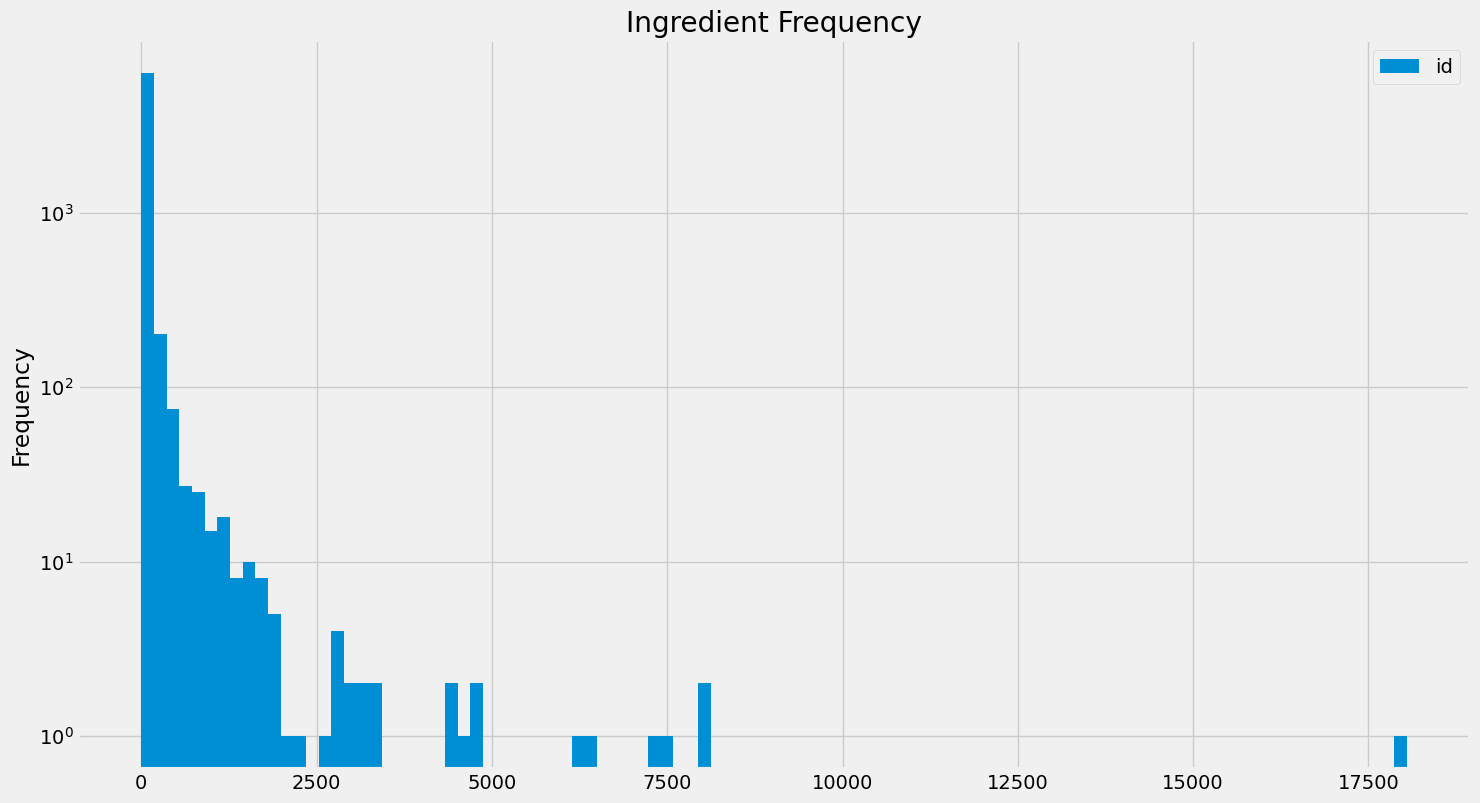

In [10]:
recipe_df = df[['id','ingredient']].drop_duplicates()\
                            .groupby('ingredient')\
                            .aggregate('count')\
                            .sort_values(by='id',
                                         ascending=False)



recipe_df.plot(kind='hist',
                   figsize=[16,9],
                   title='Ingredient Frequency',
                   bins=100, 
                   log=True)

#### Top ingredients pr. cuisine

In [11]:
## Here we find the top 5 ingredients for each cuisine
## We then create a heatmap of how common these are across regions
all_ingredients = set()
cuisine_ingredients = defaultdict(dict)
for cuisine in df['cuisine'].unique():
    view = df.loc[df['cuisine']==cuisine]
    for k,row in pd.DataFrame(view['ingredient'].value_counts()).reset_index().iterrows():
        if k < 5:
            all_ingredients.add(row['index'])
        cuisine_ingredients[cuisine][row['index']] = row['ingredient']/num_dishes.loc[num_dishes.index==cuisine]['id'].values[0]



print(len(all_ingredients))

32


In [12]:
top_ingredients_df= defaultdict(list)
for cuisine, top_ingredients in cuisine_ingredients.items():
    top_ingredients_df['cuisine'].append(cuisine)
    for ingredient in all_ingredients:
        try:
            top_ingredients_df[ingredient].append(top_ingredients[ingredient])
        except:
            top_ingredients_df[ingredient].append(None)

top_ingredients_df = pd.DataFrame(top_ingredients_df).set_index('cuisine')

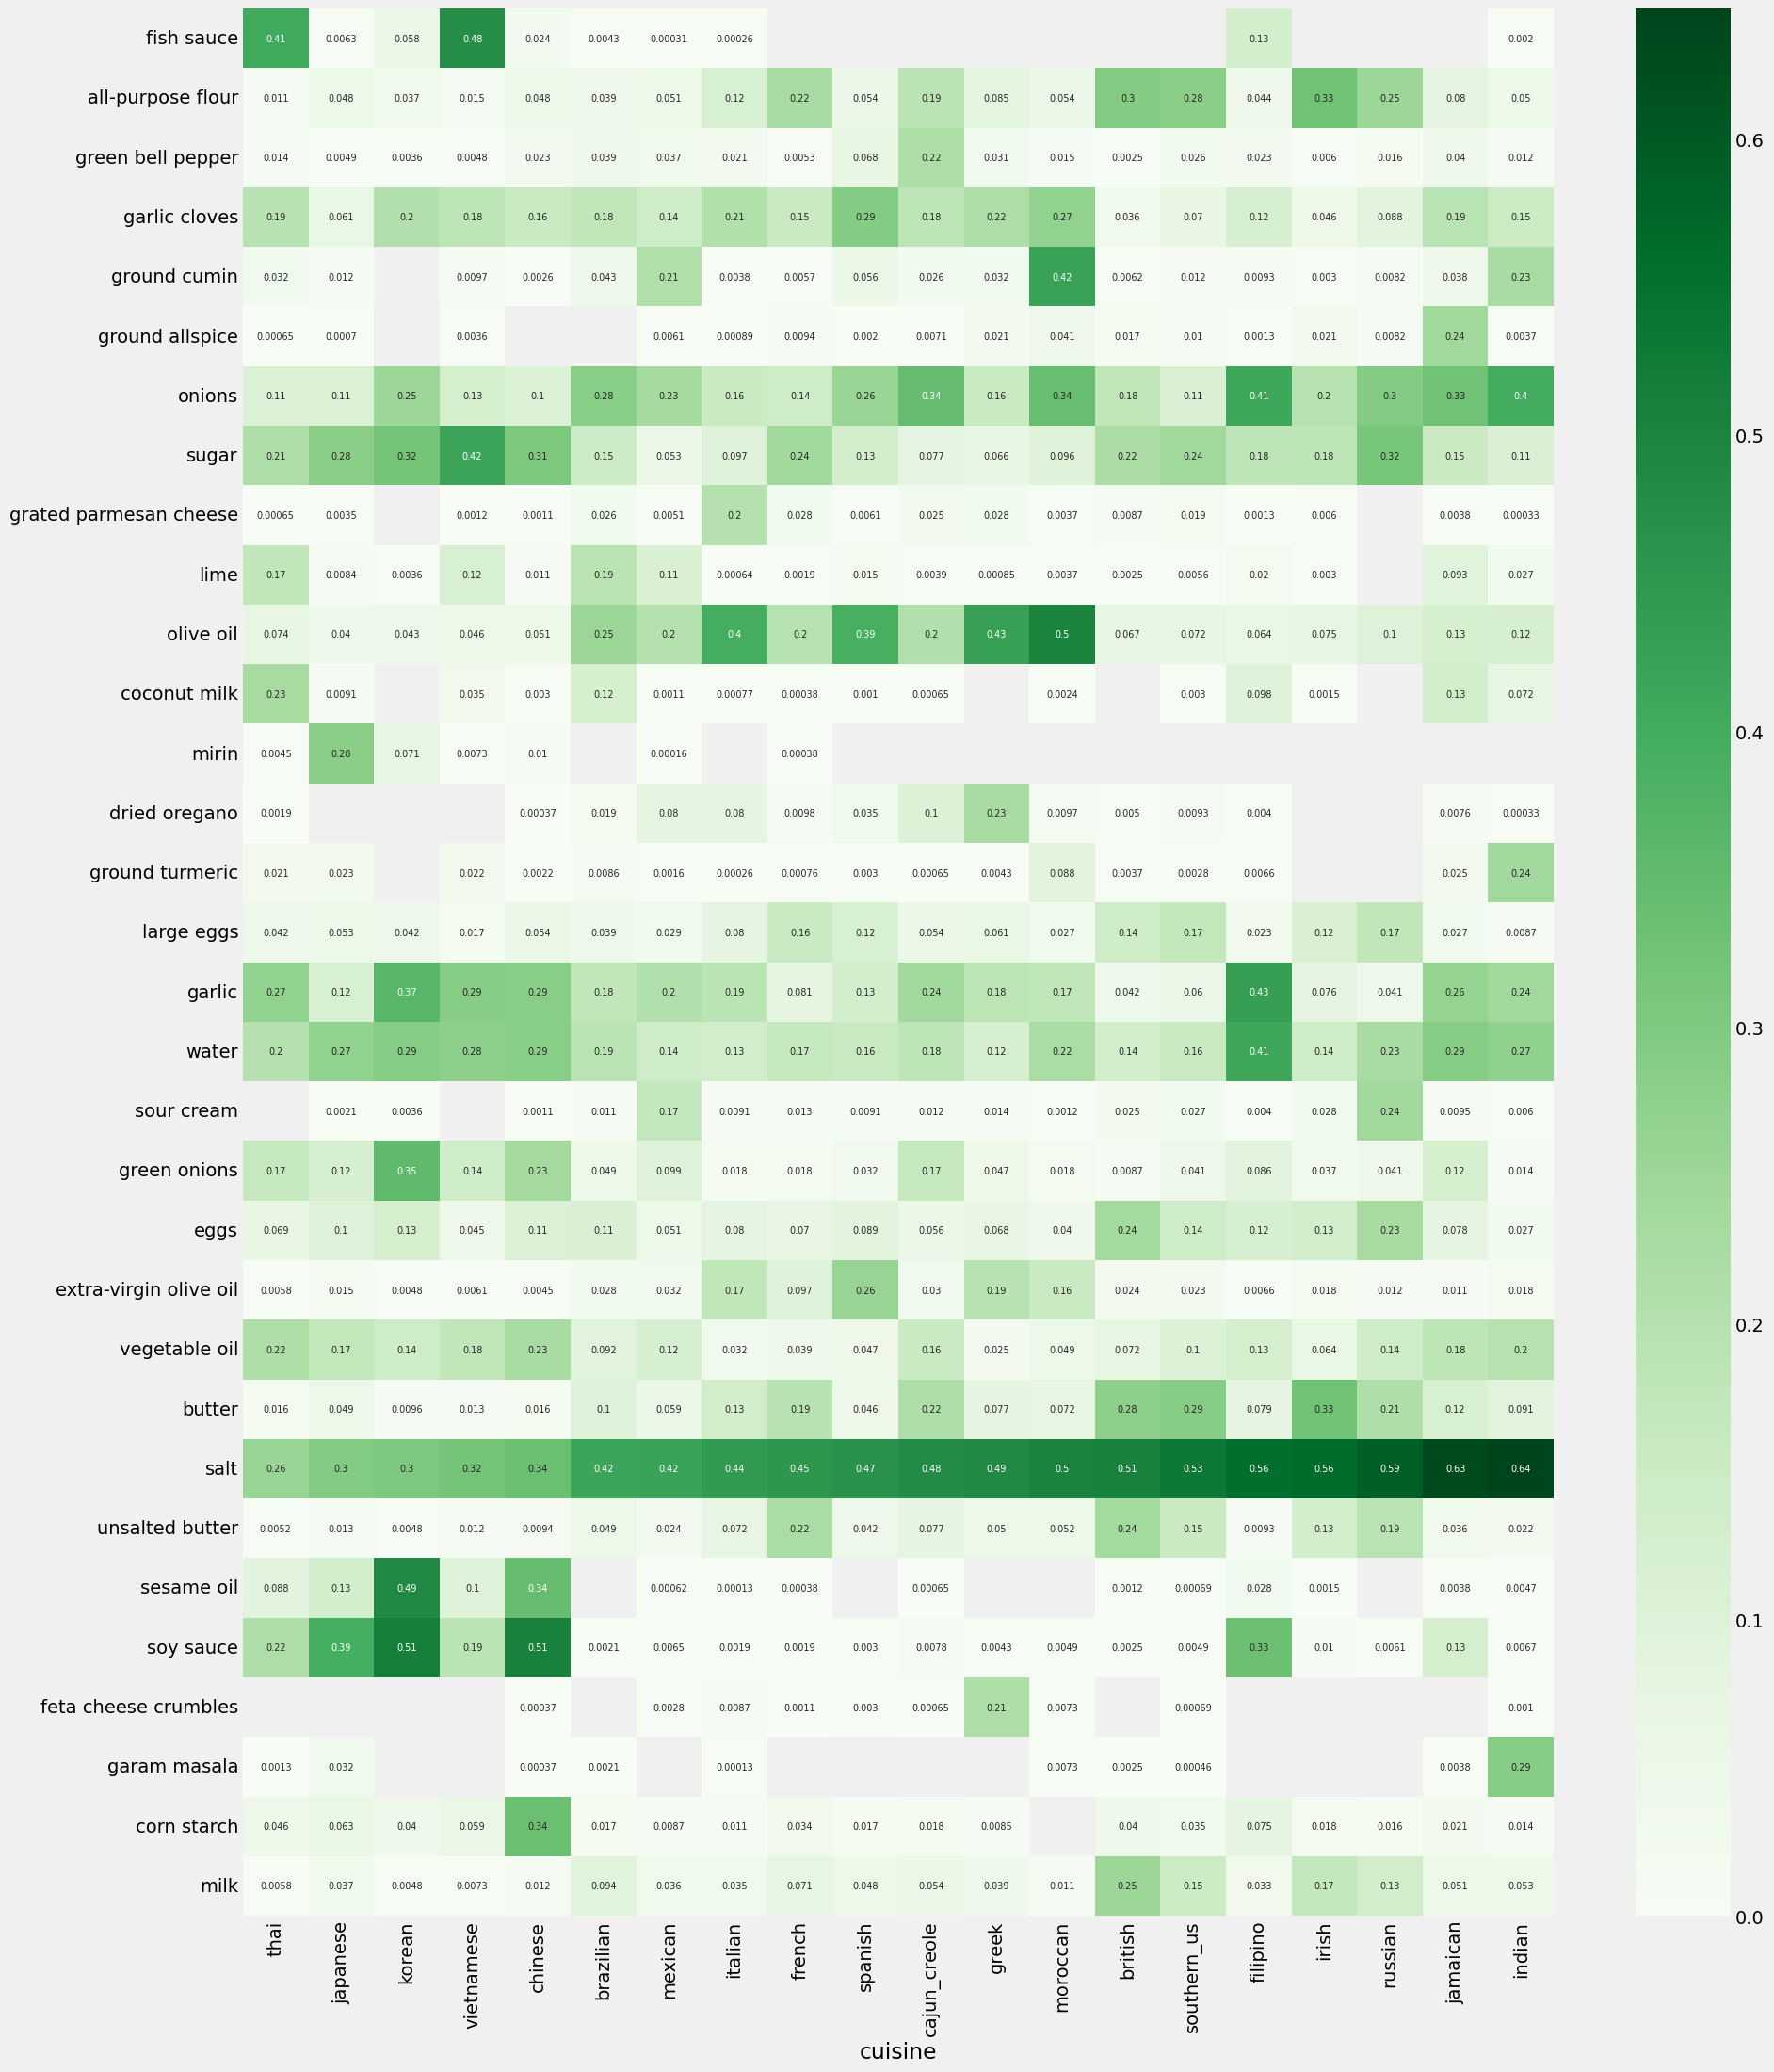

In [13]:
# This plot should
if not processed:
    plt.figure(figsize=(20,25))
    sns.heatmap(top_ingredients_df.sort_values(['salt']).transpose(), cmap='Greens', annot=True, 
                annot_kws={"size": 7}, vmin=0)
else:
    plt.figure(figsize=(20,25))
    sns.heatmap(top_ingredients_df.transpose(), cmap='Greens', annot=True, 
                annot_kws={"size": 7}, vmin=0)

#### Heatmap
Here we see that the East- and Southeast Asian cuisines are less prone to use salt. They seem to substitute this with soy- and fish sauce while also using more sugar. The E&SE-Asian countries also use very few animal product and substitutes oliveoil and butter for vegetable oil and sesame oil. 

In [14]:
recipe_map = {}
for recipe in tqdm(df['id'].unique()):
    recipe_map[recipe] = df.loc[df['id']==recipe]['ingredient'].values.tolist()

ingredient_map = {}
for ingredient in tqdm(df['ingredient'].unique()):
    ingredient_map[ingredient] = df.loc[df['ingredient']==ingredient]['id'].values.tolist()

100%|██████████| 6714/6714 [02:19<00:00, 48.17it/s]


In [15]:
## This doesn't really add value
co_occurences = defaultdict(list)
for ingredient,recipes in tqdm(ingredient_map.items()):
    for recipe in recipes:
        current_recipe = recipe_map[recipe].copy()
        current_recipe.pop(current_recipe.index(ingredient))
        co_occurences[ingredient]+=current_recipe

plot_columns = {'ingredient':[],
                'ratio':[],
                'num_recipes':[],
                'num_co_occurences':[]}
for ingredient,recipes in ingredient_map.items():
    plot_columns['ingredient'].append(ingredient)
    plot_columns['num_co_occurences'].append(len(co_occurences[ingredient]))
    plot_columns['num_recipes'].append(len(recipes))
    plot_columns['ratio'].append(len(co_occurences[ingredient])/len(recipes))

coocurence_df = pd.DataFrame(plot_columns)
coocurence_df.sort_values('num_co_occurences',ascending=False).head(20)

100%|██████████| 6714/6714 [00:00<00:00, 12611.91it/s]


,ingredient,ratio,num_recipes,num_co_occurences
11,salt,10.935564,18049,197376
35,onions,12.218766,7972,97408
3,garlic,12.171951,7380,89829
54,olive oil,11.099724,7972,88487
29,water,11.227035,7457,83720
105,garlic cloves,11.884079,6237,74121
47,sugar,10.019583,6434,64466
13,ground black pepper,11.742738,4785,56189
4,pepper,11.387787,4438,50539
19,vegetable oil,11.463854,4385,50269


In [16]:
## Global clustering coefficient
import networkx as nx
G = nx.Graph()
G_weighted = nx.Graph()
for ingredient, ingredients in tqdm(co_occurences.items()):
    for ingredient_inner,count in dict(Counter(ingredients)).items():
        G_weighted.add_edges_from([(ingredient,ingredient_inner,{'weight':count})])
        G.add_edge(ingredient,ingredient_inner)


ModuleNotFoundError: No module named 'networkx'

In [ ]:
# Here we get a hint of the overlap of the dataset
# If the the data overlaps a lot 
print(nx.average_clustering(G))
print(nx.transitivity(G))

0.7751363704331385

In [ ]:
# 


0.24442333958923965


### Answers to recipe uniqueness
We se that we a few super present ingredients, most notably, **salt** occuring in almost half the recipes in the dataset. 
We also see that the most frequent ingredients vary between cuisines.
Lastly, the *Transititvity* of the co-occurence Graph shows that about 25% of all possible triangles in the data exists. 

# EVERYTHING BELOW IS TRASH IN ITS CURRENT FORM

In [ ]:
merge_cusines = cuisines.reset_index()
merge_cusines['used_in_num_cuisines'] = merge_cusines['cuisine']
merge_cusines.drop('cuisine',axis=1,inplace=True)
ingredient_usage = df.merge(merge_cusines,on='ingredient')
ingredient_usage

,id,cuisine,ingredient,used_in_num_cuisines
0,10259,greek,romaine lettuce,13
1,242,korean,romaine lettuce,13
2,31428,mexican,romaine lettuce,13
3,45990,thai,romaine lettuce,13
4,39904,greek,romaine lettuce,13
...,...,...,...,...
428270,36135,southern_us,Lipton® Iced Tea Brew Family Size Tea Bags,1
428271,40586,greek,Hidden Valley® Greek Yogurt Original Ranch® Di...,1
428272,38509,chinese,lop chong,1
428273,10115,italian,tomato garlic pasta sauce,1


In [ ]:
ingredient_usage[['cuisine','used_in_num_cuisines']].groupby('cuisine').median().sort_values('used_in_num_cuisines')

,used_in_num_cuisines
cuisine,
thai,17.0
vietnamese,18.0
japanese,18.0
moroccan,19.0
mexican,19.0
korean,19.0
indian,19.0
brazilian,19.0
french,19.0


In [ ]:
cuisine_identifiers = ingredient_usage[['cuisine','ingredient','used_in_num_cuisines']].drop_duplicates().loc[ingredient_usage['used_in_num_cuisines']==1]
num_cuisine = cuisine_identifiers[['cuisine','used_in_num_cuisines']]\
                    .groupby('cuisine')\
                    .sum()\
                    .sort_values('used_in_num_cuisines',ascending=False)
num_cuisine

,used_in_num_cuisines
cuisine,
italian,480
mexican,456
southern_us,272
chinese,197
french,193
indian,143
japanese,139
cajun_creole,105
british,76


In [ ]:
num_cuisine_identifiers = num_dishes.merge(num_cuisine,on='cuisine')
num_cuisine_identifiers['num_dishes'] = num_cuisine_identifiers['id']
num_cuisine_identifiers.drop('id',axis=1,inplace=True)
num_cuisine_identifiers['num_identifier_pr_recipe'] = [row['used_in_num_cuisines']/row['num_dishes'] for k,row in num_cuisine_identifiers.iterrows()]
num_cuisine_identifiers.sort_values('num_identifier_pr_recipe')

,used_in_num_cuisines,num_dishes,num_identifier_pr_recipe
cuisine,,,
moroccan,34,821,0.041413
indian,143,3003,0.047619
thai,74,1539,0.048083
korean,41,830,0.049398
irish,36,667,0.053973
spanish,54,989,0.054601
greek,65,1175,0.055319
vietnamese,46,825,0.055758
italian,480,7838,0.061240


In [ ]:
unique_cuisines = df.cuisine.unique().tolist()
unique_cuisines

['greek',
 'southern_us',
 'filipino',
 'indian',
 'jamaican',
 'spanish',
 'italian',
 'mexican',
 'chinese',
 'british',
 'thai',
 'vietnamese',
 'cajun_creole',
 'brazilian',
 'french',
 'japanese',
 'irish',
 'korean',
 'moroccan',
 'russian']

In [ ]:
from scipy import stats

def jaccard(cuisine_a,cuisine_b,df=df):
    c_a = df.loc[df['cuisine']==cuisine_a]['ingredient'].unique().tolist()
    c_b = df.loc[df['cuisine']==cuisine_b]['ingredient'].unique().tolist()
    return len(np.intersect1d(c_a,c_b))/len(np.union1d(c_a,c_b))



In [ ]:
## Bences work - unsure if this should go in this part of the analysis
total_ing_cnt = Counter()
total_cousine_cnt = Counter()
cousine_wise_ing_cnt = defaultdict(Counter) 

for datapoint in tqdm(data):
    cuisine = datapoint['cuisine']
    total_cousine_cnt[cuisine] += 1
    for ing in datapoint['ingredients']:
        
        total_ing_cnt[ing] += 1
        cousine_wise_ing_cnt[cuisine][ing] += 1
        
countframe = pd.DataFrame(cousine_wise_ing_cnt).fillna(0)

100%|██████████| 39774/39774 [00:00<00:00, 104573.78it/s]


In [ ]:
def compare(metric = "jaccard",df=df,countframe=countframe):
    if metric=='jaccard':
        conf_matrix_dict = defaultdict(list)
        for c1 in tqdm(unique_cuisines):
            for c2 in unique_cuisines:
                conf_matrix_dict[c2].append(jaccard(c1,c2))
            conf_matrix_dict['cuisine'].append(c1)

        jaccard_df = pd.DataFrame(conf_matrix_dict).set_index('cuisine')
        
        return jaccard_df
    else:
        return countframe.corr(method=metric)


In [ ]:
comparison = compare('spearman')

In [ ]:
"""import seaborn as sns

plt.figure(figsize=(16,16))
sns.heatmap(jaccard_df,
            vmin=0,
            cmap='Blues',
            annot=True)"""

"import seaborn as sns\n\nplt.figure(figsize=(16,16))\nsns.heatmap(jaccard_df,\n            vmin=0,\n            cmap='Blues',\n            annot=True)"

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
def cluster_cuisines(comparison):
    plt.figure(figsize=(12,5))
    dissimilarity = 1-abs(comparison.values)
    Z = linkage(squareform(dissimilarity), 'complete')

    dendrogram(Z, labels=comparison.columns, orientation='top', 
               leaf_rotation=90)
    plt.show()
    threshold = 0.4
    labels = fcluster(Z, threshold, criterion='distance')
    return labels

In [ ]:
def create_heatmap(comparison,labels):
    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(comparison.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(comparison[i])
        else:
            df_to_append = pd.DataFrame(comparison[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)

    plt.figure(figsize=(20,20))
    correlations = clustered.corr()
    sns.heatmap(round(correlations,2), cmap='Greens', annot=True, 
                annot_kws={"size": 7}, vmin=0, vmax=0.5)

In [ ]:
def cluster_similar_cuisines(metric='spearman'):
    comparison = compare(metric)
    labels = cluster_cuisines(comparison)
    create_heatmap(comparison,labels)

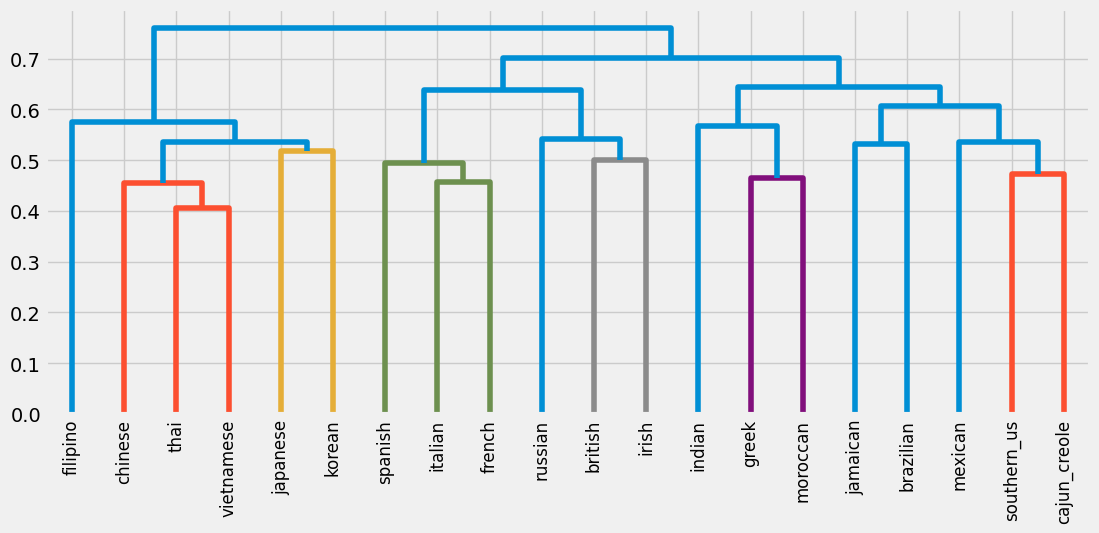

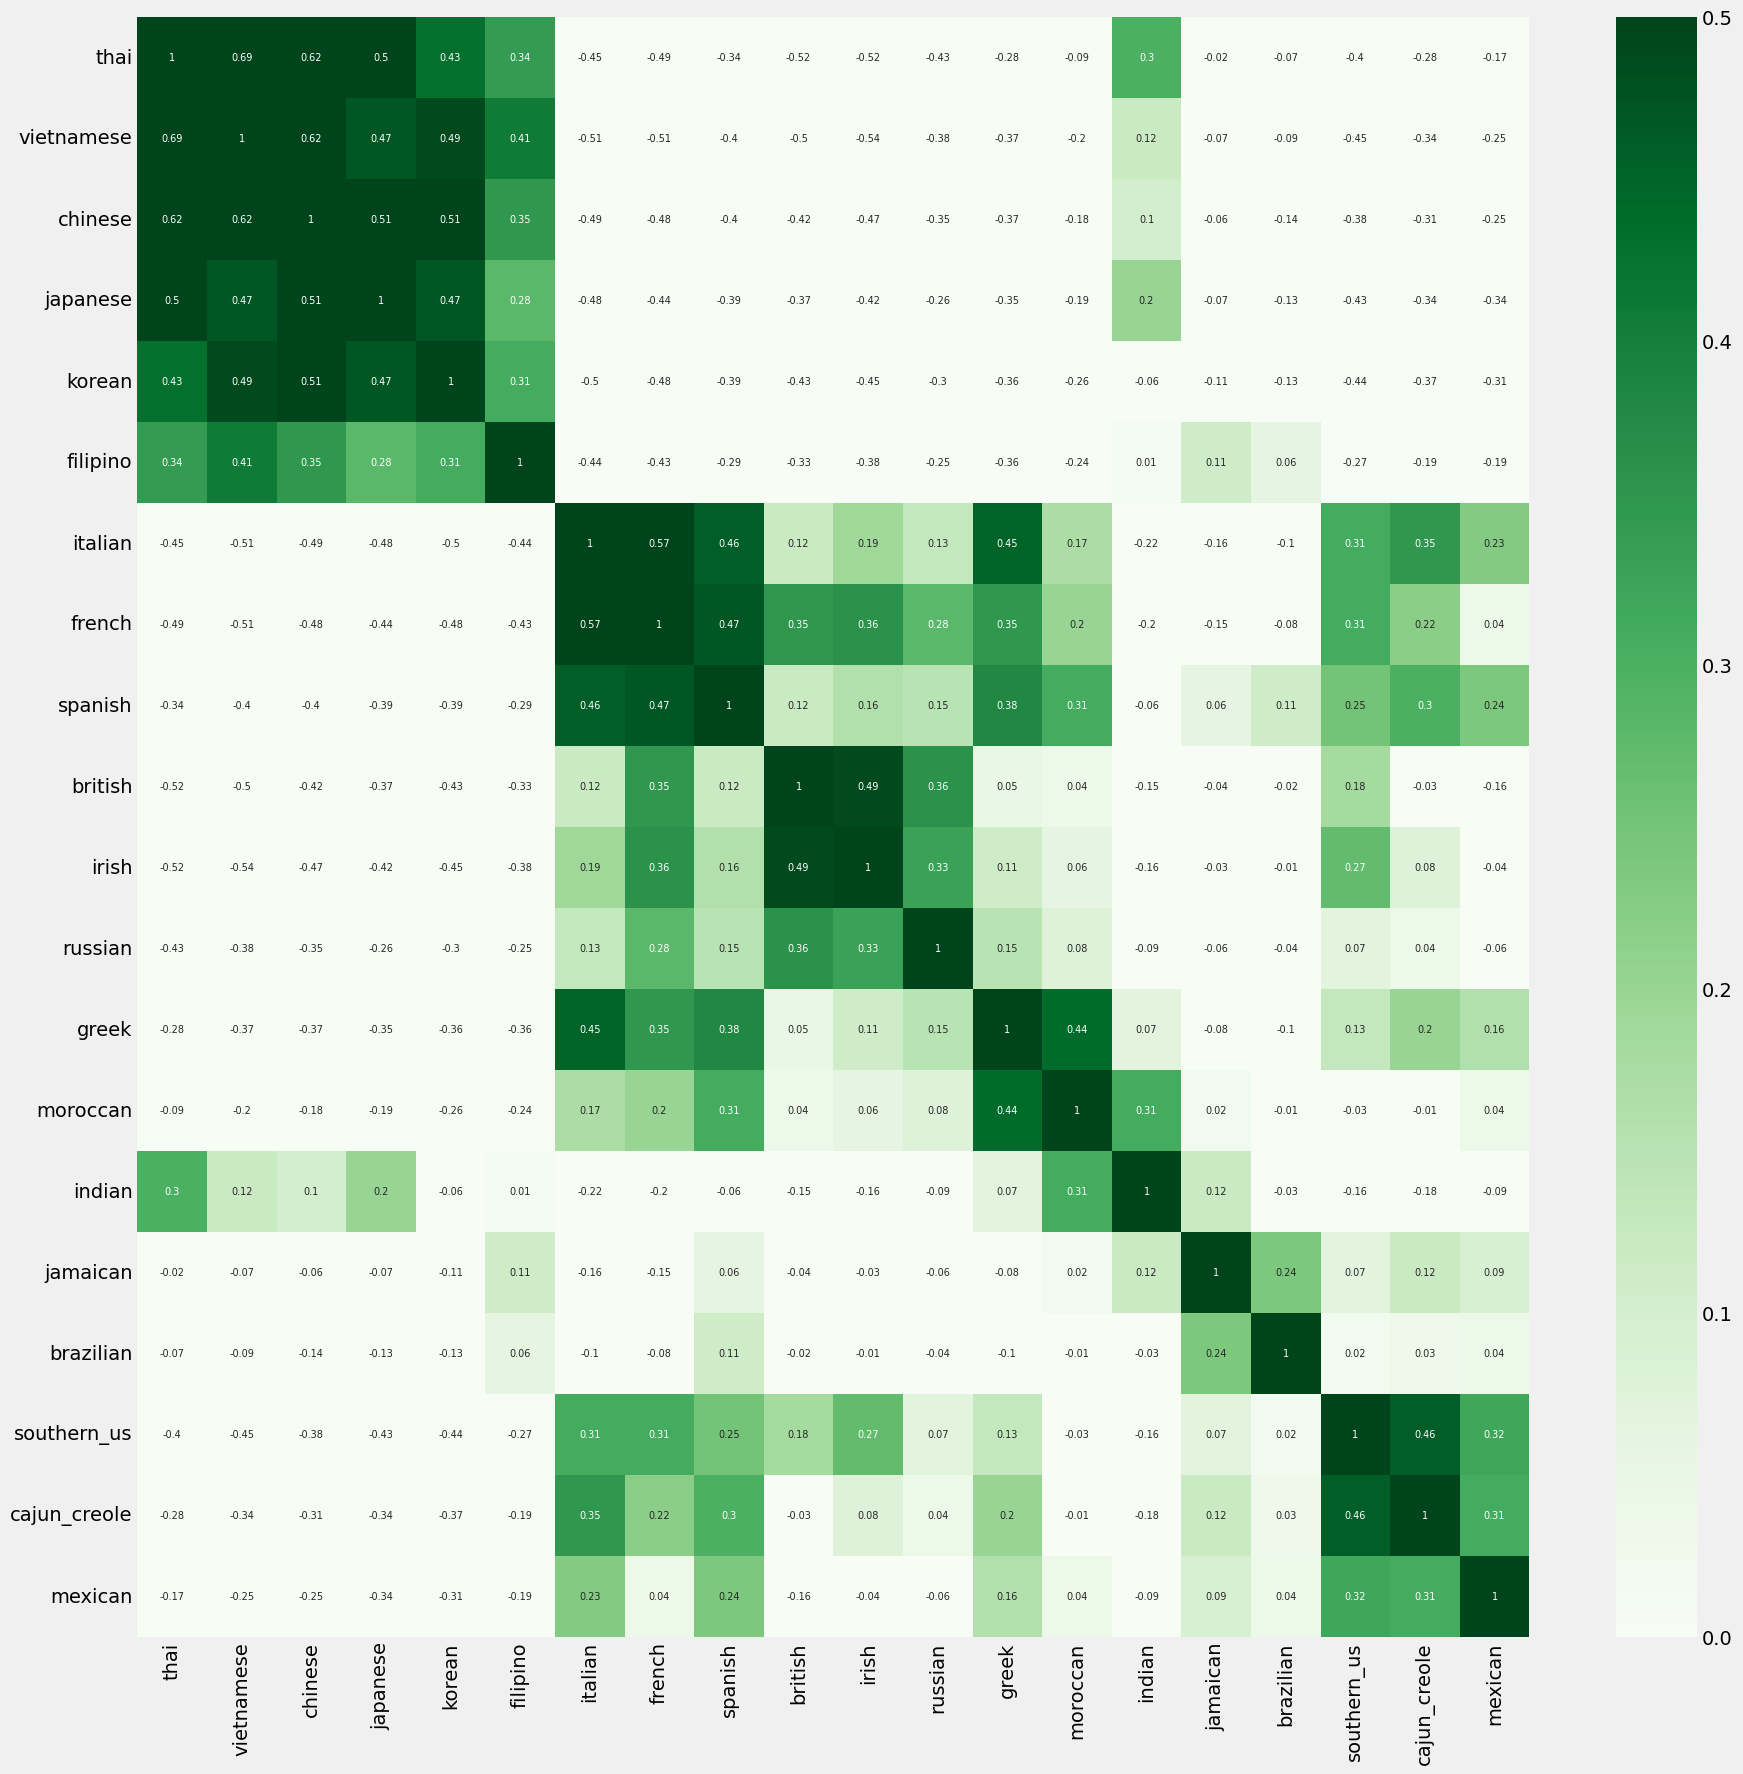

In [ ]:
cluster_similar_cuisines()

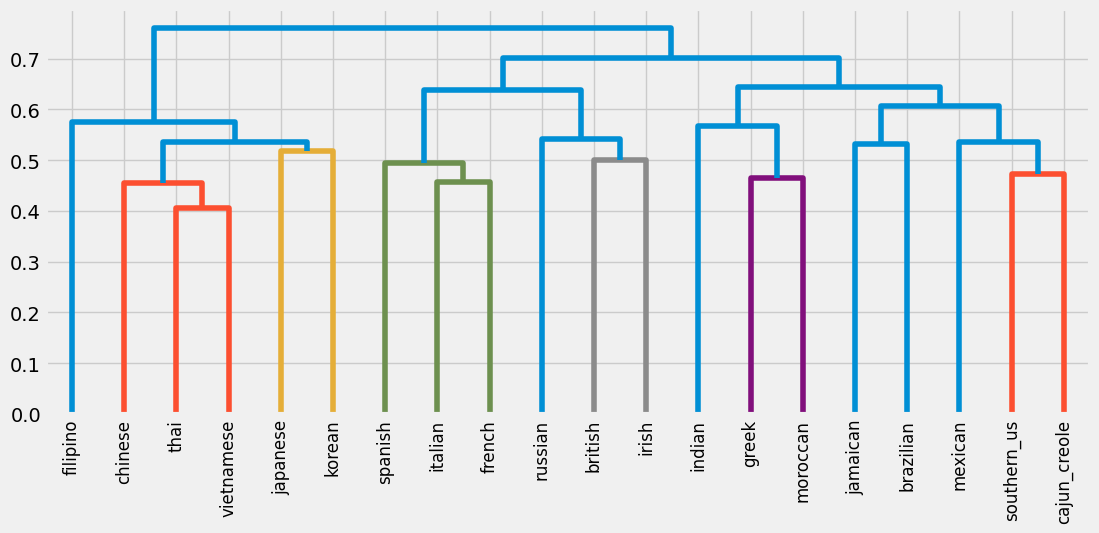

array([13, 18,  6, 15, 16,  9,  7, 20,  3, 10,  1,  2, 19, 17,  8,  4, 11,
        5, 14, 12], dtype=int32)

In [ ]:
cluster_cuisines()

In [ ]:
ketchup_ids = df.loc[df.ingredient=='ketchup'].drop_duplicates(['cuisine'])['id'].values.tolist()
ketchup_recipes = df.loc[df['id'].isin(ketchup_ids)]
for c in df.cuisine.unique():
    print('===========',c,'===========')
    for k,row in ketchup_recipes.loc[ketchup_recipes['cuisine']==c].iterrows():
        print(row['ingredient'])
    print('\n\n')

=========== greek ===========
eggs
kosher salt
parsley
purple onion
ground beef
ketchup
feta cheese
red wine vinegar
smoked paprika
oregano
brown sugar
whole grain mustard
cinnamon
dry bread crumbs
glaze
black pepper
cayenne
garlic
fresh mint



=========== southern_us ===========
ketchup
honey
Tabasco Pepper Sauce
freshly ground pepper
onions
kosher salt
unsalted butter
heavy cream
thyme
extra sharp cheddar cheese
molasses
ground black pepper
vegetable oil
garlic cloves
grits
chicken broth
cider vinegar
bourbon whiskey
cayenne pepper
chopped parsley
large shrimp



=========== filipino ===========
ginger ale
ground black pepper
freshly ground pepper
soy sauce
garlic
bamboo shoots
white vinegar
ketchup
salt
mango
brown sugar
crushed garlic
pork shoulder



=========== indian ===========
ketchup
milk
butter
sour cream
ground turmeric
tomatoes
pepper
garam masala
salt
onions
ground ginger
chicken bouillon
garbanzo beans
garlic
coconut milk
ground paprika
curry powder
potatoes
ground almo

In [ ]:
ketchup_recipes.loc[ketchup_recipes['cuisine']==c]

,id,cuisine,ingredient
340568,11139,greek,eggs
340569,11139,greek,kosher salt
340570,11139,greek,parsley
340571,11139,greek,purple onion
340572,11139,greek,ground beef
340573,11139,greek,ketchup
340574,11139,greek,feta cheese
340575,11139,greek,red wine vinegar
340576,11139,greek,smoked paprika
340577,11139,greek,oregano
